In [1]:
import pickle
import matplotlib 
matplotlib.use("Agg")

In [2]:
prototxt="models/pascal_voc/VGG16/faster_rcnn_alt_opt/faster_rcnn_test.pt"
pretrained="data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel"

In [3]:
%matplotlib inline

In [4]:
import sys
sys.path.append("caffe-fast-rcnn/python/")
sys.path.append("lib/")

In [5]:
import caffe

In [24]:
caffe.set_mode_gpu
caffe.set_device(0)

In [9]:
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

In [10]:
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2

In [22]:
def vis_detections(im, class_name, dets, thresh=0.5, name="a"):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(name+".pdf")
    plt.draw()
    

In [45]:
!curl -o auto1.jpg http://www.pda.profi-forex.org/system/news/IMG_7122.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  137k  100  137k    0     0   158k      0 --:--:-- --:--:-- --:--:--  158k


In [46]:
im=cv2.imread("auto1.jpg")

In [47]:
net=caffe.Net(prototxt, pretrained, caffe.TEST)

In [48]:
cfg.GPU_ID = 0
cfg.TEST.HAS_RPN = True
timer = Timer()
timer.tic()
scores, boxes = im_detect(net, im)
timer.toc()
print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

Detection took 26.724s for 300 object proposals


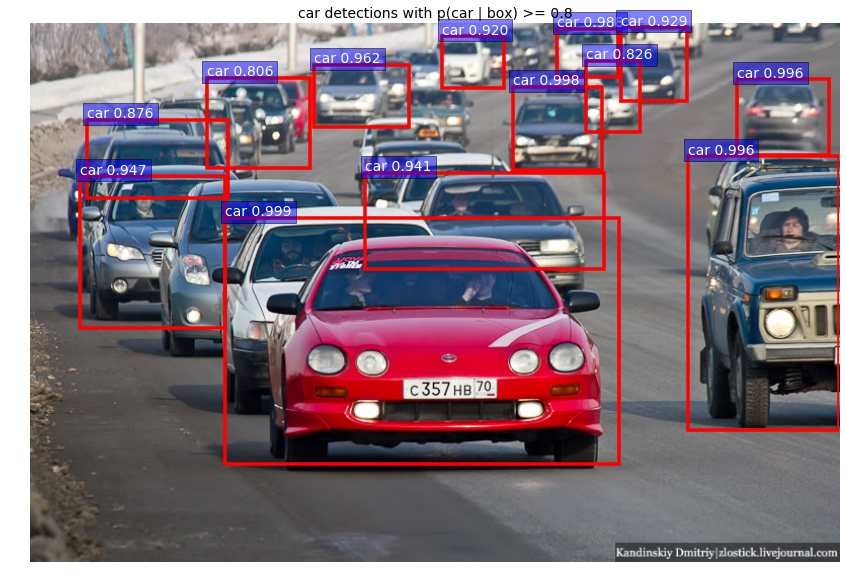

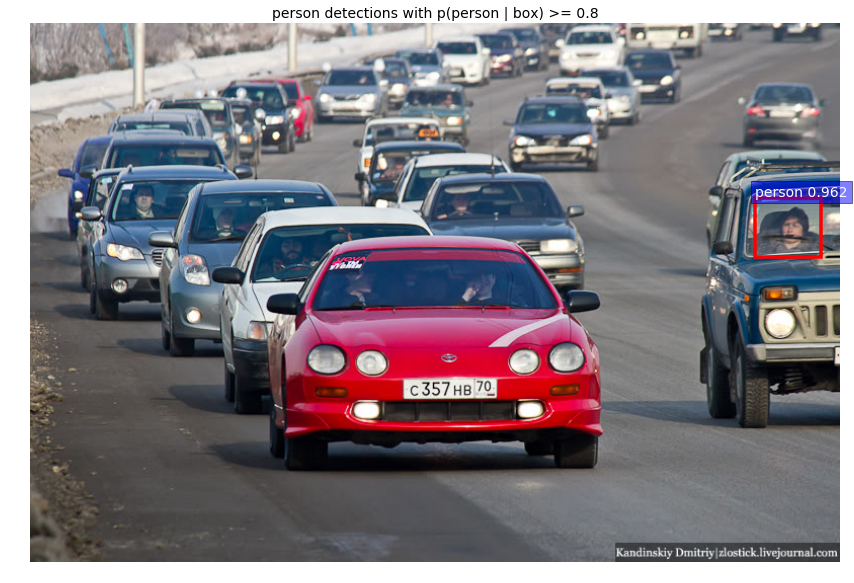

In [49]:
CONF_THRESH = 0.8
NMS_THRESH = 0.3
for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH,name="samolet")